In [1]:
# 1. Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:

# 2. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 3. Path directory for the dataset
data_dir = '/content/drive/MyDrive/DR_50'
train_dir = '/content/drive/MyDrive/DR_50/Train'
test_dir = '/content/drive/MyDrive/DR_50/Test'
valid_dir = '/content/drive/MyDrive/DR_50/Valid'

In [4]:
# 4. Augmentation of the images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# 5. Train the model
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),  # GoogleNet requires input size 299x299
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical')

# Load InceptionV3 pre-trained on ImageNet without the top layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Save the model summary
model.summary()

# Train the model
epochs = 20
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)

Found 175 images belonging to 5 classes.
Found 50 images belonging to 5 classes.
87910968/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                               

Found 25 images belonging to 5 classes.
1/1 [==============================] - 15s 15s/step
Accuracy: 0.44
Precision: 0.2866666666666666
Recall: 0.44
F1 Score: 0.339047619047619
Confusion Matrix:
[[0 1 0 3 1]
 [0 3 0 2 0]
 [1 0 0 1 3]
 [0 1 0 3 1]
 [0 0 0 0 5]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


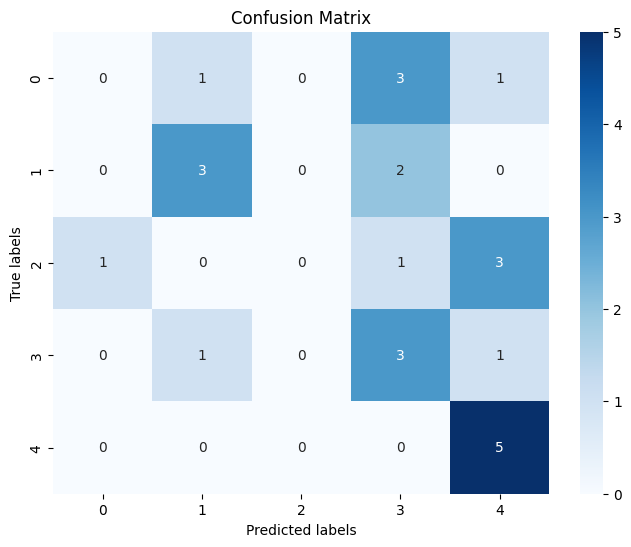

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 6. Calculate performance metrics
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# Predict classes
y_pred = model.predict(test_generator)
y_pred_classes = y_pred.argmax(axis=-1)

# True classes
true_classes = test_generator.classes

# Performance metrics
accuracy = accuracy_score(true_classes, y_pred_classes)
precision = precision_score(true_classes, y_pred_classes, average='weighted')
recall = recall_score(true_classes, y_pred_classes, average='weighted')
f1 = f1_score(true_classes, y_pred_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
